In [1]:
import torch
from torch import nn
from torchvision import datasets,transforms
from torchvision.models import vgg16_bn,VGG16_BN_Weights
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
trans=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [3]:
target_trans=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.PILToTensor()
])

In [4]:
train_data=datasets.VOCSegmentation(root='data',download=False,
                                    image_set='train',transform=trans,target_transform=target_trans,
                                    )
val_data=datasets.VOCSegmentation(root='data',download=False,
                                  image_set='val',transform=trans,target_transform=target_trans)

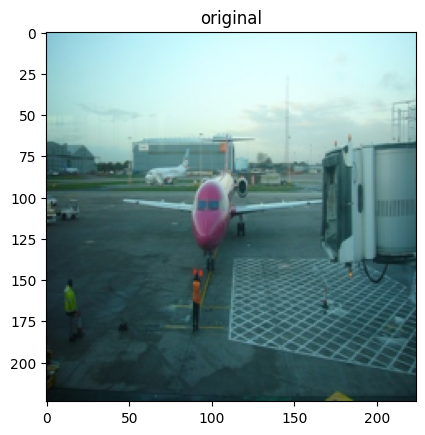

In [5]:
plt.imshow(train_data[0][0].permute(1,2,0))
plt.title('original')
plt.show()

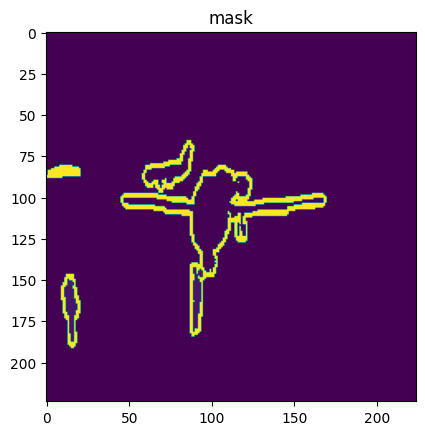

In [6]:
plt.imshow(train_data[0][1].permute(1,2,0))
plt.title('mask')
plt.show()

In [7]:
train_ds=DataLoader(dataset=train_data,shuffle=True,batch_size=32,num_workers=4)
val_ds=DataLoader(val_data,batch_size=32)

In [8]:
def try_gpu():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

In [9]:
## 网络结构
class FCN8S(torch.nn.Module):
    def __init__(self,out_channels=21):
        super().__init__()
        self.backend=vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1).features
        self.down1=self.backend[0:24]##32,3,28,28
        self.down2=self.backend[24:34]#32,3,14,14
        self.down3=self.backend[34:]#32,3,7,7
        self.conv3=nn.Sequential(
            nn.Conv2d(512,1024,kernel_size=1,padding=0,stride=1,padding_mode='reflect'),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )
        self.conv32=nn.Sequential(
            nn.Conv2d(1024,512,kernel_size=1,padding=0,stride=1,padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.up_3=nn.ConvTranspose2d(512,512,kernel_size=4,stride=2,padding=1)
        self.conv2=nn.Sequential(nn.Conv2d(512,512,kernel_size=1,padding=0,stride=1),
                                 nn.BatchNorm2d(512),
                                 nn.ReLU())
        self.up_2=nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1)
        self.conv1=nn.Sequential(nn.Conv2d(256,256,kernel_size=1,padding=0,stride=1),
                                 nn.BatchNorm2d(256),
                                 nn.ReLU())
        self.up_1=nn.ConvTranspose2d(256,out_channels,kernel_size=16,stride=8,padding=4)
    def forward(self,x):
        out_1=self.down1(x)
        out_2=self.down2(out_1)
        out_3=self.down3(out_2)

        out_3=self.conv3(out_3)
        out_3=self.conv32(out_3)
        out_3=self.up_3(out_3)
        out_2=self.conv2(out_2)

        out=out_2+out_3
        out=self.up_2(out)

        out_1=self.conv1(out_1)
        out = out + out_1

        out=self.up_1(out)
        return out

In [10]:
## 打印网络
fcn=FCN8S()
print(fcn)

FCN8S(
  (backend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

In [11]:
## 检验输出大小
X=torch.randn(32,3,224,224)
fcn(X).shape

torch.Size([32, 21, 224, 224])

In [12]:
## 损失函数
class FocalLoss(nn.Module):
    def __init__(self,alpha=0.25,gamma=2,ignore_dix=255, *args, **kwargs,):
        super().__init__(*args, **kwargs)
        self.alpha=alpha
        self.gamma=gamma
        self.ignore_dix=ignore_dix
    def forward(self,inputs,targets):
        predict=inputs.permute(0,2,3,1).contiguous()
        predict=torch.softmax(predict,dim=-1)
        b,c=predict.size(0),predict.size(3)
        mask=targets!=self.ignore_dix#(batch_size,h,w)
        predict=predict[mask].view(-1,c)
        targets=targets[mask].view(-1)
        one_hot=torch.eye(c,device=predict.device)
        targets=one_hot[targets].view(-1,c).float()#(predict_size,c)
        FL=((-self.alpha*((1-predict)**self.gamma))*targets*torch.log2(predict+1e-12)).sum(dim=-1)#(predict_size,)
        return FL.mean()

In [13]:
## 定义累加器
class Accumulator():
    def __init__(self,n):
        self.data=[0.0]*n
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
    def reset(self):
        self.data=[0.0]*len(self.data)
    def __getitem__(self, item):
        return self.data[item]

In [14]:
## 训练函数
def train(net,train_iter,lr,loss,num_epches,device=None):
    def init_weights(m):
        if type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    history=[]
    net.apply(init_weights)
    net.to(device)
    print(f"training on {device}")
    loss=loss
    optimizer=torch.optim.Adam(net.parameters(),lr=lr,weight_decay=1e-4)
    batch_size=len(train_iter)
    for epoch in range(num_epches):
        metric=Accumulator(2)
        net.train()
        print(f"epoch{epoch+1}:")
        for i,(X,y) in enumerate(train_iter):
            X,y=X.to(device),y.to(device)
            y_hat=net(X)
            y=y.squeeze(1).long()
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.sum().backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l,l.numel())
            if (i+1)%(batch_size//5)==0 or i==batch_size-1:
                print(f"\tloss: {metric[0]/metric[1]:.3f}")
        history.append(metric[0]/metric[1])
        print(f'epoch {epoch+1} summary: loss {metric[0]/metric[1]:.3f}')   
    return history

In [34]:
## 开始训练！
history=train(fcn,train_ds,lr=0.001,loss=FocalLoss(),num_epches=60,device=try_gpu())

training on cuda
epoch1:
	loss: 0.386
	loss: 0.359
	loss: 0.349
	loss: 0.342
	loss: 0.342
	loss: 0.340
epoch 1 summary: loss 0.340
epoch2:
	loss: 0.300
	loss: 0.299
	loss: 0.304
	loss: 0.306
	loss: 0.308
	loss: 0.308
epoch 2 summary: loss 0.308
epoch3:
	loss: 0.285
	loss: 0.296
	loss: 0.297
	loss: 0.299
	loss: 0.297
	loss: 0.296
epoch 3 summary: loss 0.296
epoch4:
	loss: 0.300
	loss: 0.292
	loss: 0.296
	loss: 0.289
	loss: 0.290
	loss: 0.288
epoch 4 summary: loss 0.288
epoch5:
	loss: 0.273
	loss: 0.281
	loss: 0.287
	loss: 0.283
	loss: 0.278
	loss: 0.279
epoch 5 summary: loss 0.279
epoch6:
	loss: 0.269
	loss: 0.271
	loss: 0.274
	loss: 0.271
	loss: 0.276
	loss: 0.275
epoch 6 summary: loss 0.275
epoch7:
	loss: 0.278
	loss: 0.268
	loss: 0.263
	loss: 0.267
	loss: 0.268
	loss: 0.266
epoch 7 summary: loss 0.266
epoch8:
	loss: 0.278
	loss: 0.263
	loss: 0.259
	loss: 0.263
	loss: 0.262
	loss: 0.263
epoch 8 summary: loss 0.263
epoch9:
	loss: 0.254
	loss: 0.252
	loss: 0.258
	loss: 0.257
	loss: 0.25

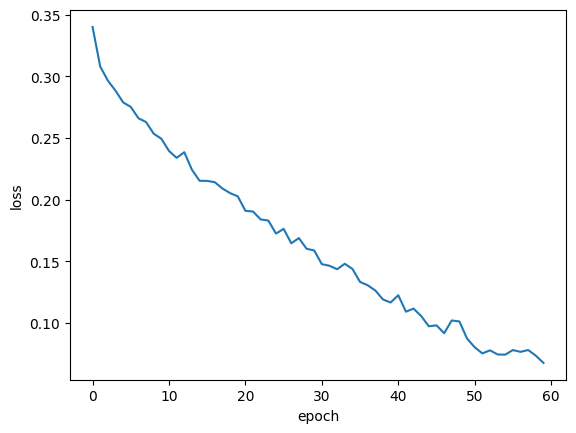

In [35]:
plt.plot(history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 在验证集上测试模型

In [54]:
## 定义预测函数
def predict(net,data_iter,num=15,idx=2):
    iters=iter(data_iter)
    for j in range(idx-1):
        next(iters)
    image,target=next(iters)
    images,targets=[],[]
    net.to(try_gpu())
    net.eval()
    with torch.no_grad():
        pred=net(image.to(try_gpu()))
    for i in range(num):
        images.append(image[i].permute(1,2,0).detach().cpu())
        targets.append(target[i].permute(1,2,0).detach().cpu())
    return images,targets,pred

In [56]:
predicted=preds.argmax(1)
predicted.shape

torch.Size([32, 224, 224])

In [57]:
preds=[predicted[i].detach().cpu() for i in range(15)]
len(preds)

15

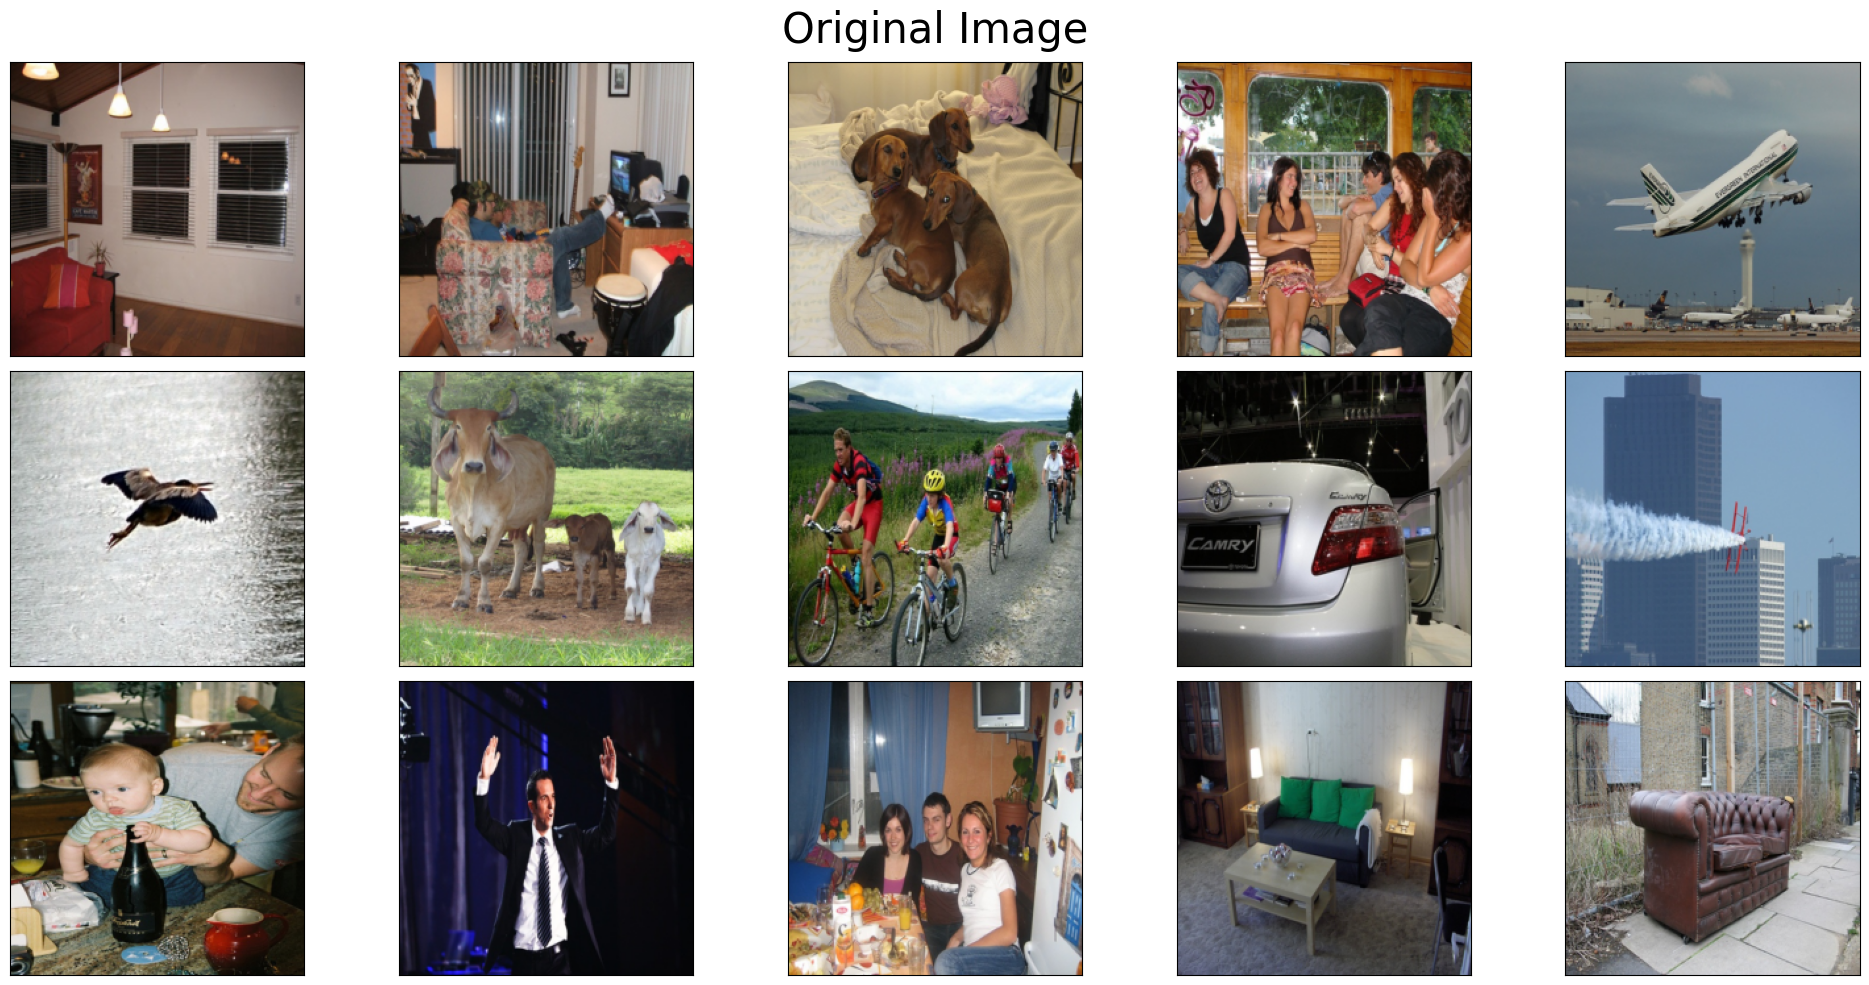

In [58]:
fig,axes=plt.subplots(3,5,figsize=(20,10))
for i in range(3):
    for j in range(5):
        axes[i,j].imshow(origin[j+i*5])
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
plt.suptitle('Original Image',fontsize=30)
fig.tight_layout()
plt.show()

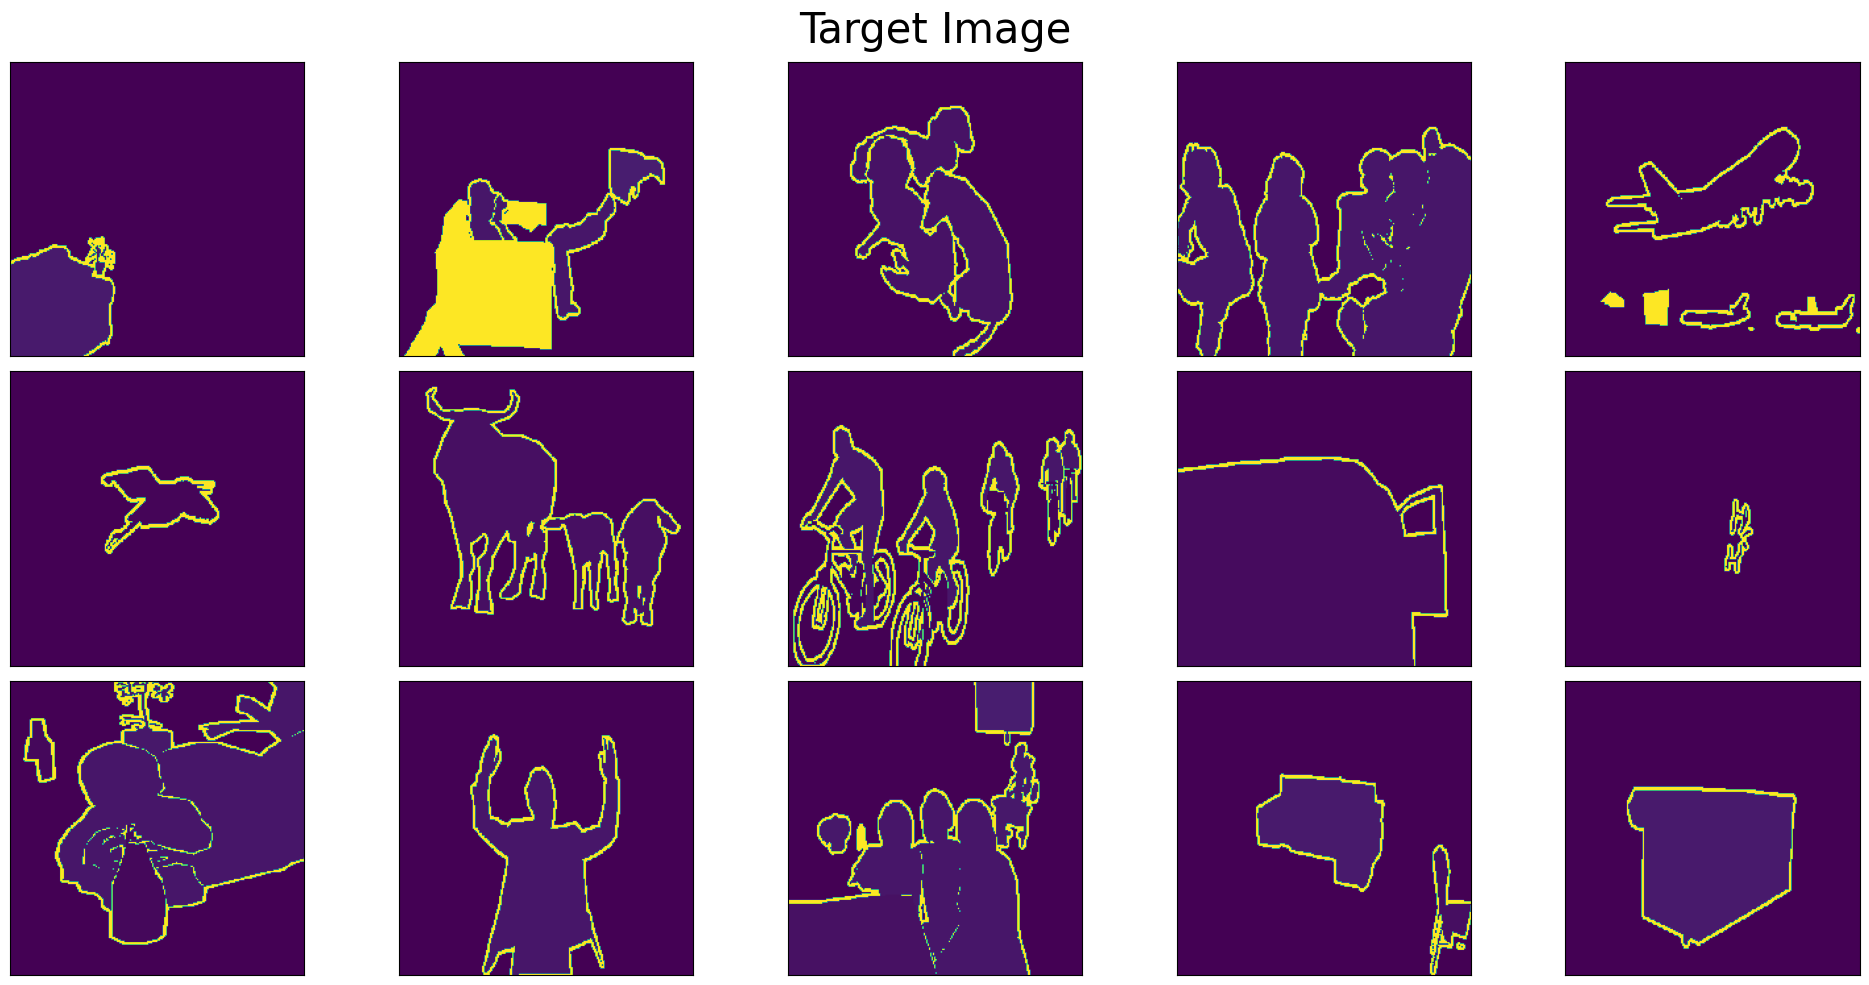

In [59]:
fig,axes=plt.subplots(3,5,figsize=(20,10))
for i in range(3):
    for j in range(5):
        axes[i,j].imshow(targets[j+i*5])
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
plt.suptitle('Target Image',fontsize=30)
fig.tight_layout()
plt.show()

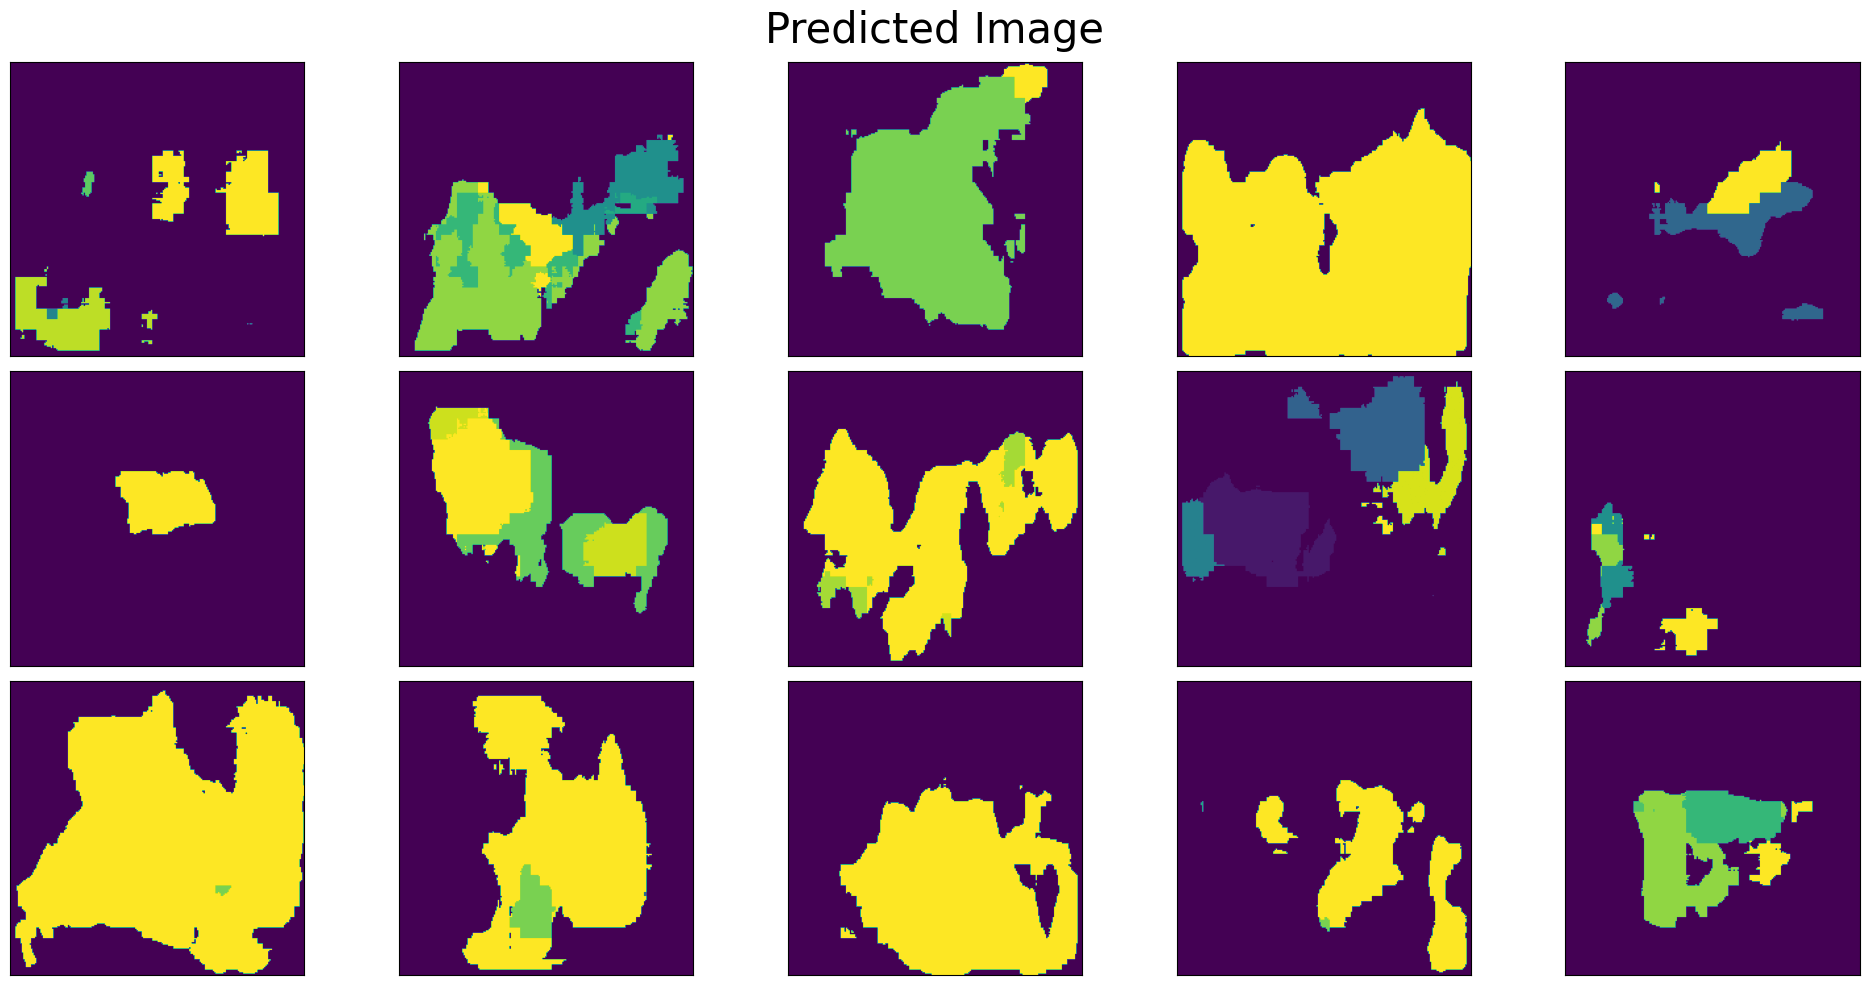

In [60]:
fig,axes=plt.subplots(3,5,figsize=(20,10))
for i in range(3):
    for j in range(5):
        axes[i,j].imshow(preds[j+i*5])
        axes[i,j].set_xticks(())
        axes[i,j].set_yticks(())
plt.suptitle('Predicted Image',fontsize=30)
fig.tight_layout()
plt.show()

## 恭喜！你已经成功训练了一个FCN-8S模型。
### 但是可以看见FCN模型在边缘部分比较粗糙，但是主体还是能看出来的，如果你对语义分割感兴趣，不妨试试Unet,这是一个更有效的模型